In [1]:
import numpy as np
import pandas as pd
from scipy.signal import correlate
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import matplotlib
from itertools import product
from scipy.optimize import dual_annealing, minimize

In [2]:

df_eye_all = pd.read_csv('processed_data\processed_data_asc_task_fractals_all_post_process_indiv.csv')
df_cam_all = pd.read_csv('processed_data\processed_data_tiny_task_fractals_all_post_process_indiv.csv')


In [3]:
df_eye_all

,Time,RX,RY,state,participants,flag,emotion_side,RX_,RY_
0,50513516.0,832.7,769.8,0.0,P006,-1,N,832.7,769.8
1,50513517.0,837.5,770.3,0.0,P006,-1,N,837.5,770.3
2,50513518.0,840.7,770.6,0.0,P006,-1,N,840.7,770.6
3,50513519.0,845.0,771.3,0.0,P006,-1,N,845.0,771.3
4,50513520.0,848.0,771.7,0.0,P006,0,N,848.0,771.7
...,...,...,...,...,...,...,...,...,...
2663017,428107947.0,828.5,502.0,1.0,P210,1,R,828.5,502.0
2663018,428107948.0,828.2,502.9,1.0,P210,1,R,828.2,502.9
2663019,428107949.0,828.4,500.7,1.0,P210,1,R,828.4,500.7
2663020,428107950.0,828.1,498.4,1.0,P210,1,R,828.1,498.4


In [4]:


def find_optimal_transformation(X_tiny, X_eyelink, grid_size=100, scale_N=2, shift_N=3):
    """
    Find optimal scale and shift to transform X_tiny to match X_eyelink using dual annealing
    followed by gradient descent fine-tuning. Warns if optimal values are at boundaries.
    Handles positive and negative mean_diff for shift_range.
    
    Parameters:
    X_tiny: numpy array, input data to be transformed
    X_eyelink: numpy array, target data
    grid_size: int, number of points for range definition (used for bounds)
    scale_N: float, multiplier for scale range
    shift_N: float, multiplier for shift range
    
    Returns:
    best_scale, best_shift: optimal transformation parameters
    """
    
    # Define ranges for bounds
    scale_range = np.linspace(np.std(X_eyelink)/(scale_N*np.std(X_tiny)),
                             scale_N*np.std(X_eyelink)/np.std(X_tiny), grid_size)
    
    reverse_scaling = np.std(X_tiny)/np.std(X_eyelink)
    mean_diff = np.mean(X_eyelink) - np.mean(X_tiny)/reverse_scaling
    
    print(f"Reverse scaling: {reverse_scaling:.4f}")
    print(f"Mean difference: {mean_diff:.4f}")
    
    # Define shift_range, handling positive and negative mean_diff
    epsilon = 1e-6
    if mean_diff == 0:
        shift_range = np.linspace(-epsilon, epsilon, grid_size)
    else:
        center = reverse_scaling * mean_diff
        width = reverse_scaling * abs(mean_diff) * shift_N
        shift_range = np.linspace(center - width, center + width, grid_size)

    # Define bounds for dual annealing
    bounds = [(scale_range[0], scale_range[-1]), (shift_range[0], shift_range[-1])]
    
    # Objective function: MSE between transformed X_tiny and X_eyelink
    def objective(params):
        scale, shift = params
        transformed = scale * (X_tiny + shift)
        return np.mean((transformed - X_eyelink) ** 2)
    
    # Run dual annealing
    result = dual_annealing(objective, bounds, seed=42)
    best_scale, best_shift = result.x
    
    # Check if optimal values are at boundaries
    if np.isclose(best_scale, scale_range[0]) or np.isclose(best_scale, scale_range[-1]):
        print(f"Warning: Optimal scale ({best_scale:.4f}) is at the boundary of the grid "
              f"(range: [{scale_range[0]:.4f}, {scale_range[-1]:.4f}]). "
              "Consider increasing the scale_N or grid_size.")
    if np.isclose(best_shift, shift_range[0]) or np.isclose(best_shift, shift_range[-1]):
        print(f"Warning: Optimal shift ({best_shift:.4f}) is at the boundary of the grid "
              f"(range: [{shift_range[0]:.4f}, {shift_range[-1]:.4f}]). "
              "Consider increasing the shift_N or grid_size.")
    
    # Gradient descent fine-tuning using BFGS
    result = minimize(objective, x0=[best_scale, best_shift], method='BFGS')
    best_scale, best_shift = result.x
    
    return best_scale, best_shift



PID P006 → global lag = 97.0 ms
Reverse scaling: 1.4109
Mean difference: 305.5666
Participant; P006, Optimal scale: 0.6711, Optimal shift: 505.0957
PID P008 → global lag = 82.0 ms
Reverse scaling: 0.7951
Mean difference: -386.5538
Participant; P008, Optimal scale: 1.2108, Optimal shift: -277.5222
PID P020 → global lag = 77.0 ms
Reverse scaling: 1.1312
Mean difference: 317.6555
Participant; P020, Optimal scale: 0.8170, Optimal shift: 451.9513
PID P036 → global lag = 84.0 ms
Reverse scaling: 1.1350
Mean difference: 404.8480
Participant; P036, Optimal scale: 0.7998, Optimal shift: 578.0669
PID P063 → global lag = 46.0 ms
Reverse scaling: 1.2852
Mean difference: 259.4107
Participant; P063, Optimal scale: 0.7352, Optimal shift: 402.3046
PID P065 → global lag = -45.0 ms
Reverse scaling: 0.0000
Mean difference: -1246142082542285568.0000
Participant; P065, Optimal scale: 1861166229444719.0000, Optimal shift: -710.9336
PID P070 → global lag = 66.0 ms
Reverse scaling: 1.4253
Mean difference: 364

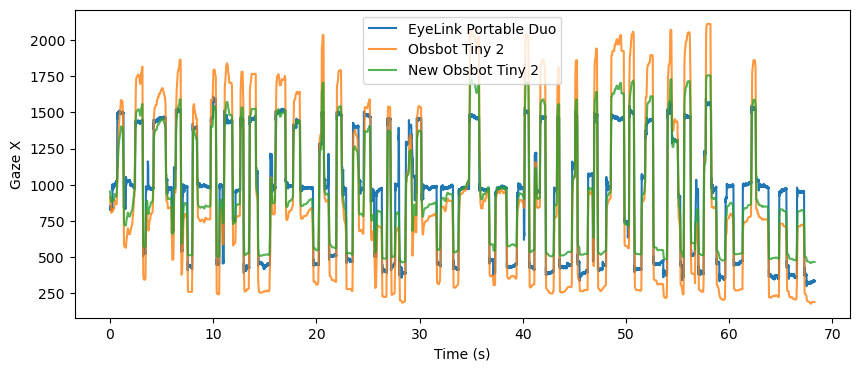

In [ ]:


df_eye_all.rename(columns={'Time': 'time', 'RX_': 'x', 'RY_': 'y', 'participants': 'participant'}, inplace=True)
df_cam_all.rename(columns={'eyelink_time': 'time', 'post_calX': 'x', 'participants': 'participant'}, inplace=True)

# compute each participant’s eye‐start and subtract from both streams
df_eye_all['t0_ms'] = df_eye_all.groupby('participant')['time'].transform('first')
df_eye_all['t_ms0'] = df_eye_all['time'] - df_eye_all['t0_ms']

t0_df = df_eye_all[['participant','t0_ms']].drop_duplicates()
df_cam_all = df_cam_all.merge(t0_df, on='participant', how='left')
df_cam_all['t_ms0'] = df_cam_all['time'] - df_cam_all['t0_ms']


# CLEAN + GLOBAL‐LAG FUNCTION (ms)
def clean_and_estimate_global_lag_ms(eye_df, cam_df,
                                     max_interp_gap_ms=300,
                                     max_search_ms=500):
    # eye time grid & sampling interval
    t_eye = eye_df['t_ms0'].values
    dt = np.median(np.diff(t_eye))                 
    # max_gap_samps = max(1, int(max_interp_gap_ms / dt))

    df = eye_df.copy()
    df['x_imputed'] = df['x'].interpolate(
        method='linear',  limit_direction='both'
    )
    good = np.isfinite(df['x_imputed'])
    df['good_mask'] = good

    #  raw start‐time offset (ms)
    raw_offset = cam_df['t_ms0'].iloc[0] - eye_df['t_ms0'].iloc[0]
    t_cam_aligned = cam_df['t_ms0'].values - raw_offset

    # interpolate cam.x onto the eye time grid
    x_cam_on_t = np.interp(t_eye, t_cam_aligned, cam_df['x'].values)

    # Build a mask of valid (finite) samples in both streams
    good_eye = np.isfinite(eye_df['x'].values)
    good_cam = np.isfinite(x_cam_on_t)
    good     = good_eye & good_cam
    if good.sum() < 2:
        raise ValueError("Not enough overlapping valid samples to estimate lag.")

    # Cross-correlate over only the “good” points, restricted to ±max_search_ms
    xr = eye_df['x'].values[good]
    xc = x_cam_on_t[good]
    xr = xr - xr.mean()
    xc = xc - xc.mean()

    cc    = correlate(xc, xr, mode='full', method='direct')
    lags  = np.arange(-len(xc)+1, len(xr))
    max_p = int(max_search_ms / dt)
    valid = np.abs(lags) <= max_p

    best   = lags[valid][np.argmax(cc[valid])]
    lag_ms = best * dt
    return df, lag_ms


# LOCAL‐WARP FUNCTION (seconds)
def align_by_local_correlation(t_ref, x_ref, t_cam, x_cam,
                               window_sec=2.0, step_sec=0.5,
                               max_lag_sec=0.5, smooth_spline_s=1e-2,
                               spline_k=3, min_samples_per_win=10):
    """
    Time‐warp camera timestamps to match reference.
    """
    # sliding‐window centers
    t0, t1 = t_ref[0], t_ref[-1]
    centers = np.arange(t0 + window_sec/2,
                        t1 - window_sec/2 + 1e-8,
                        step_sec)
    center_list, lag_list = [], []

    for tc in centers:
        w0, w1 = tc - window_sec/2, tc + window_sec/2
        mask_ref = (t_ref>=w0)&(t_ref<=w1)
        mask_cam = (t_cam>=w0-max_lag_sec)&(t_cam<=w1+max_lag_sec)

        xr = x_ref[mask_ref]; tr = t_ref[mask_ref]
        xc = x_cam[mask_cam]; tc_sub = t_cam[mask_cam]
        if len(xr)<min_samples_per_win or len(xc)<min_samples_per_win:
            continue

        N = max(len(xr), len(xc), 200)
        uni_t = np.linspace(w0, w1, N)
        xr_u = np.interp(uni_t, tr, xr)
        xc_u = np.interp(uni_t, tc_sub, xc)

        max_pts = int(max_lag_sec / (uni_t[1]-uni_t[0]))
        cc = correlate(xc_u - xc_u.mean(),
                       xr_u - xr_u.mean(),
                       mode='full')
        lags_pts = np.arange(-len(xc_u)+1, len(xr_u))
        valid = np.abs(lags_pts) <= max_pts
        lags_sub, cc_sub = lags_pts[valid], cc[valid]
        best = lags_sub[np.argmax(cc_sub)]
        lag_sec = best * (uni_t[1]-uni_t[0])

        center_list.append(tc)
        lag_list.append(lag_sec)

    centers = np.array(center_list); lags = np.array(lag_list)
    if len(lags) <= 1:
        const = float(lags[0]) if len(lags)==1 else 0.0
        lag_fn = lambda t: const
    else:
        k_fit = min(spline_k, len(lags)-1)
        lag_fn = UnivariateSpline(centers, lags, k=k_fit, s=smooth_spline_s)

    t_cam_corr = t_cam - lag_fn(t_cam)
    return t_cam_corr, lag_fn



aligned_results = []

# per participant
for pid in df_eye_all['participant'].unique():
    eye = df_eye_all[df_eye_all.participant==pid].reset_index(drop=True)
    cam = df_cam_all[df_cam_all.participant==pid].reset_index(drop=True)
    if cam.empty:
        print(f"PID {pid}: no camera data, skipping.")
        continue

    # clean + compute refined global lag (ms)
    eye_clean, lag_ms = clean_and_estimate_global_lag_ms(eye, cam)
    print(f"PID {pid} → global lag = {lag_ms:.1f} ms")

    # apply constant shift & convert to seconds
    cam['t_shifted_s'] = (cam['t_ms0'] - lag_ms) / 1000.0
    t_ref = eye_clean['t_ms0'].values / 1000.0
    x_ref = eye_clean['x_imputed'].values
    t_cam = cam['t_shifted_s'].values
    x_cam = cam['x'].values

    # fine align using local correlation
    t_cam_corr, lag_fn = align_by_local_correlation(
        t_ref, x_ref, t_cam, x_cam,
        window_sec=1.8, step_sec=0.5, max_lag_sec=0.5, smooth_spline_s=1e-2
    )

    # interpolate tiny camera signals onto eyelink time grid
    eye_clean['x_cam_aligned'] = np.interp(t_ref, t_cam_corr, cam['x'].values)
    # eye_clean['y_cam_aligned'] = np.interp(t_ref, t_cam_corr, cam['y'].values)

    # use grid search to find the optimal scale and shift
    optimal_scale, optimal_shift = find_optimal_transformation(np.array(eye_clean['x_cam_aligned']), np.array(eye_clean['x_imputed']) ,grid_size=100, scale_N=2, shift_N=5)
    print(f"Participant; {pid}, Optimal scale: {optimal_scale:.4f}, Optimal shift: {optimal_shift:.4f}")
    
    # apply the optimal scale and shift to tiny data
    eye_clean['new_tinyX'] = optimal_scale * (np.array(eye_clean['x_cam_aligned'].values) + optimal_shift)

    aligned_results.append({
        'participant': pid,
        'eye_aligned_df': eye_clean,
        'cam_aligned_df': cam.assign(t_cam_corr_s=t_cam_corr),
        'global_lag_ms': lag_ms,
        'lag_fn': lag_fn
    })

all_aligned = pd.concat(
    [res['eye_aligned_df'] for res in aligned_results],
    ignore_index=True
)

res0 = aligned_results[0]
eye0 = res0['eye_aligned_df']
plt.figure(figsize=(10,4))
plt.plot(eye0['t_ms0']/1000.0, eye0['x_imputed'],      label='EyeLink Portable Duo')
plt.plot(eye0['t_ms0']/1000.0, eye0['x_cam_aligned'], label='Obsbot Tiny 2', alpha=0.8)
plt.plot(eye0['t_ms0']/1000.0, eye0['new_tinyX'], label='New Obsbot Tiny 2', alpha=0.8)
plt.xlabel('Time (s)'); plt.ylabel('Gaze X'); plt.legend(); plt.show()


In [6]:
# eleminating participant P065 at index 5
# del aligned_results[5]

In [7]:
for i in range(len(aligned_results)):
    aligned_results[i]['eye_aligned_df'] = aligned_results[i]['eye_aligned_df'][aligned_results[i]['eye_aligned_df']['flag'] != -1].reset_index(drop=True)

In [8]:
for i in range(len(aligned_results)):
    # detect the start of each 0-run
    is_cycle_start = (
        (aligned_results[i]['eye_aligned_df']['flag'] == 0) 
        & (aligned_results[i]['eye_aligned_df']['flag'].shift(fill_value=-1) != 0)
    )

    # cumulatively count those starts to get a cycle ID
    aligned_results[i]['eye_aligned_df']['interval_num'] = is_cycle_start.cumsum()
  

In [9]:
task_data_df = []
for i in range(len(aligned_results)):
    for data in aligned_results[i]['eye_aligned_df'].groupby('interval_num'):
        task_data_df.append(data[1].reset_index(drop=True))

In [10]:
task_data_df[2]

,time,RX,RY,state,participant,flag,emotion_side,x,y,t0_ms,t_ms0,x_imputed,good_mask,x_cam_aligned,new_tinyX,interval_num
0,50516934.0,529.3,510.3,1.0,P006,0,N,529.3,510.3,50513516.0,3418.0,529.3,True,349.753610,573.696602,3
1,50516935.0,527.8,509.7,1.0,P006,0,N,527.8,509.7,50513516.0,3419.0,527.8,True,349.868102,573.773439,3
2,50516936.0,526.5,511.3,1.0,P006,0,N,526.5,511.3,50513516.0,3420.0,526.5,True,349.982595,573.850276,3
3,50516937.0,527.2,513.3,1.0,P006,0,N,527.2,513.3,50513516.0,3421.0,527.2,True,350.097087,573.927113,3
4,50516938.0,529.2,515.2,1.0,P006,0,N,529.2,515.2,50513516.0,3422.0,529.2,True,350.211580,574.003950,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702,50518636.0,1464.7,563.4,1.0,P006,1,L,1464.7,563.4,50513516.0,5120.0,1464.7,True,1666.973823,1457.694180,3
1703,50518637.0,1464.8,563.1,1.0,P006,1,L,1464.8,563.1,50513516.0,5121.0,1464.8,True,1666.973823,1457.694180,3
1704,50518638.0,1464.6,562.2,1.0,P006,1,L,1464.6,562.2,50513516.0,5122.0,1464.6,True,1666.973823,1457.694180,3
1705,50518639.0,1463.6,558.7,1.0,P006,1,L,1463.6,558.7,50513516.0,5123.0,1463.6,True,1666.904582,1457.647712,3


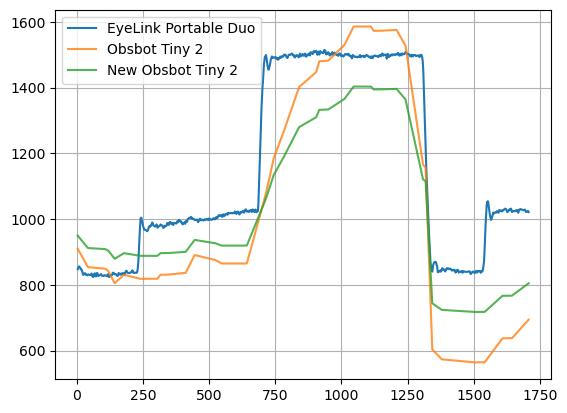

In [11]:
for i in range(1):
    plt.plot(task_data_df[i]['t_ms0'], task_data_df[i]['x_imputed'], label='EyeLink Portable Duo')
    plt.plot(task_data_df[i]['t_ms0'], task_data_df[i]['x_cam_aligned'], label='Obsbot Tiny 2', alpha=0.8)
    plt.plot(task_data_df[i]['t_ms0'], task_data_df[i]['new_tinyX'], label='New Obsbot Tiny 2', alpha=0.8)
    plt.grid(True)
    plt.legend()
    plt.show()

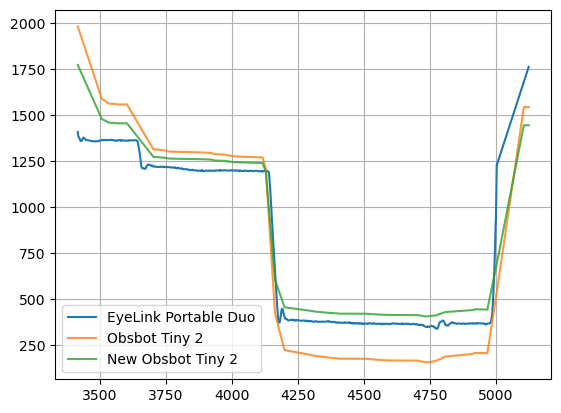

In [12]:
plt.plot(task_data_df[1482]['t_ms0'], task_data_df[1482]['x_imputed'], label='EyeLink Portable Duo')
plt.plot(task_data_df[1482]['t_ms0'], task_data_df[1482]['x_cam_aligned'], label='Obsbot Tiny 2', alpha=0.8)
plt.plot(task_data_df[1482]['t_ms0'], task_data_df[1482]['new_tinyX'], label='New Obsbot Tiny 2', alpha=0.8)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
dwell_time_saccade_asc = []
dwell_time_saccade_tiny = []
countnan = 0
looked_at_asc = []
looked_at_tiny = []

# for i in range(1480,1485):
for i in range(len(task_data_df)):
    first_idxs = task_data_df[i].groupby('flag')['flag'].agg('idxmin')
    task_data_df[i] = task_data_df[i].reset_index(drop=True)
    index_to_highlight = first_idxs[1]
    fractal_side = task_data_df[i]['emotion_side'][index_to_highlight]

    saccade_start_saccade_asc_1 =np.append( np.where((task_data_df[i]['x_imputed'][index_to_highlight:] > 1200) & (task_data_df[i]['x_imputed'][499:] < 1680))[0],10000)
    saccade_start_saccade_asc_2 = np.append( np.where((task_data_df[i]['x_imputed'][index_to_highlight:] < 720) & (task_data_df[i]['x_imputed'][499:] > 240))[0],10000)
    
    saccade_start_saccade_tiny_1 =np.append( np.where((task_data_df[i]['new_tinyX'][index_to_highlight:] > 1200) & (task_data_df[i]['new_tinyX'][499:] < 1680))[0],10000)
    saccade_start_saccade_tiny_2 = np.append( np.where((task_data_df[i]['new_tinyX'][index_to_highlight:] < 720) & (task_data_df[i]['new_tinyX'][499:] > 240))[0],10000)
    
    

    if saccade_start_saccade_asc_1[0] < saccade_start_saccade_asc_2[0]:
        dwell_time_saccade_asc.append(len(saccade_start_saccade_asc_1)-1)
        if fractal_side == 'R':
            looked_at_asc.append([fractal_side, 1])
        else:
            looked_at_asc.append([fractal_side, 0])
    else:
        dwell_time_saccade_asc.append(len(saccade_start_saccade_asc_2)-1)
        if fractal_side == 'L':
            looked_at_asc.append([fractal_side, 1])
        else:
            looked_at_asc.append([fractal_side, 0])
    
    if saccade_start_saccade_tiny_1[0] < saccade_start_saccade_tiny_2[0]:
        dwell_time_saccade_tiny.append(len(saccade_start_saccade_tiny_1)-1)
        if fractal_side == 'R':
            looked_at_tiny.append([fractal_side, 1])
        else:
            looked_at_tiny.append([fractal_side, 0])
    else:
        dwell_time_saccade_tiny.append(len(saccade_start_saccade_tiny_2)-1)
        if fractal_side == 'L':
            looked_at_tiny.append([fractal_side, 1])
        else:
            looked_at_tiny.append([fractal_side, 0])
    
    

    # if (saccade_start_saccade_asc < 10000) and (saccade_start_saccade_asc > 0) and (saccade_start_saccade_tiny > 0) and (saccade_start_saccade_tiny < 10000):
    #     dwell_time_saccade_asc.append(saccade_start_saccade_asc)
    #     dwell_time_saccade_tiny.append(saccade_start_saccade_tiny)

In [36]:
s_looked_at_tiny = np.array(np.swapaxes(looked_at_tiny,0,1)[1])
s_looked_at_asc = np.array(np.swapaxes(looked_at_asc,0,1)[1])

In [37]:
np.sum(s_looked_at_asc==s_looked_at_tiny)/len(s_looked_at_asc)

0.8961538461538462

In [38]:
unique_vals, counts = np.unique(s_looked_at_tiny, return_counts=True)
tiny_count = dict(zip(unique_vals, counts))

In [39]:
tiny_count

{'0': 845, '1': 715}

In [40]:
unique_vals, counts = np.unique(s_looked_at_asc, return_counts=True)
asc_count = dict(zip(unique_vals, counts))

In [41]:
asc_count

{'0': 835, '1': 725}

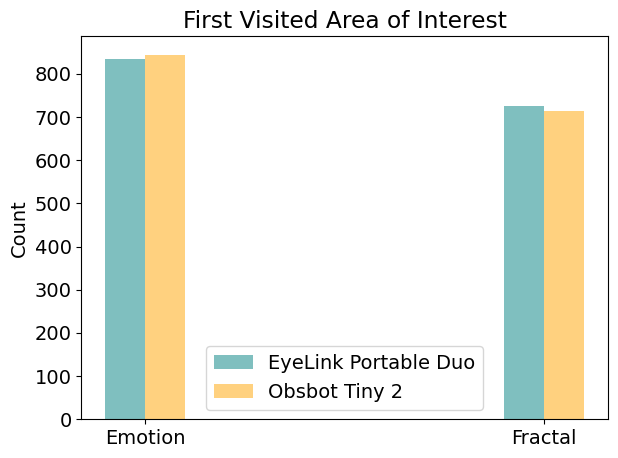

In [42]:
matplotlib.rcParams.update({'font.size':14})

# Get shared keys and their values
labels = list(asc_count.keys())
values1 = [asc_count[k] for k in labels]
values2 = [tiny_count[k] for k in labels]

x = np.arange(len(labels))  # label locations
width = 0.1  # width of bars

fig, ax = plt.subplots()
ax.bar(x - width/2, values1, width, color='teal', alpha=0.5, label='EyeLink Portable Duo')
ax.bar(x + width/2, values2, width, color='orange', alpha=0.5, label='Obsbot Tiny 2')

ax.set_ylabel('Count')
ax.set_title('First Visited Area of Interest')
ax.set_xticks(x)
ax.set_xticklabels(['Emotion','Fractal'])
ax.legend()
fig.tight_layout()



In [43]:
len(dwell_time_saccade_tiny)

1560

In [61]:
len(dwell_time_saccade_asc)

1560

In [45]:
mask1 = np.array(dwell_time_saccade_asc)>30
mask2 = np.array(dwell_time_saccade_tiny)>30

mask = mask1*mask2

new_dwell_time_saccade_asc = np.array(dwell_time_saccade_asc)[mask]
new_dwell_time_saccade_tiny = np.array(dwell_time_saccade_tiny)[mask]

In [62]:
with open('./Plots and Files/fractals_task/dwell_time_fractals_eyelink.txt', 'w') as f:
    f.writelines(f"{rt}\n" for rt in dwell_time_saccade_asc)

with open('./Plots and Files/fractals_task/dwell_time_fractals_tiny.txt', 'w') as f:
    f.writelines(f"{rt}\n" for rt in dwell_time_saccade_tiny)

In [46]:
b = "D"        
p = "\u209C"   # superscript 2
Df= "{}{}".format(b, p)

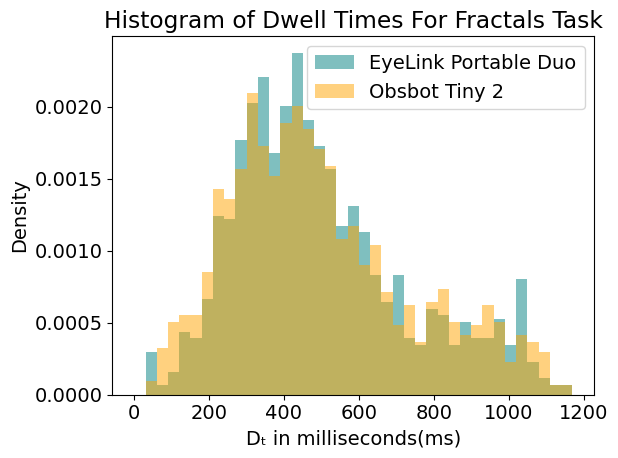

In [63]:
matplotlib.rcParams.update({'font.size':14})

plt.hist(np.array(dwell_time_saccade_asc)[mask], np.arange(0,1200,30), color='teal', density = True, alpha=0.5, label='EyeLink Portable Duo')
# plt.hist(np.array(dwell_time_saccade_asc), np.arange(0,1200,30), color='teal', density = True, alpha=0.5, label='EyeLink Portable Duo')
# plt.hist(dwell_time_saccade_tiny, np.arange(100,1200,30), color='orange', density = True, alpha=0.5, label='EyeLink Portable Duo')
plt.hist(np.array(dwell_time_saccade_tiny)[mask], np.arange(0,1200,30), color='orange', density = True, alpha=0.5, label='Obsbot Tiny 2')
plt.ylabel('Density')
plt.xlabel(f'{Df} in milliseconds(ms)')
plt.title('Histogram of Dwell Times For Fractals Task')
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
def to_quantiles(arr):
    """
    Transform an array so each value is replaced by its quantile in the distribution.
    
    Parameters:
    arr: numpy array, input data to be transformed
    
    Returns:
    quantiles: numpy array, quantile values (between 0 and 1) corresponding to each input value
    """
    # Convert input to numpy array
    arr = np.asarray(arr)
    
    # Get ranks (using 'average' method for ties)
    ranks = np.argsort(np.argsort(arr, kind='mergesort'))  # Stable sort for consistency
    n = len(arr)
    
    # Convert ranks to quantiles: (rank + 0.5) / n for centered quantiles
    quantiles = (ranks + 0.5) / n
    
    return quantiles

In [49]:
q = to_quantiles(new_dwell_time_saccade_asc)
q

array([0.74880383, 0.83082707, 0.90669856, ..., 0.48017772, 0.32433356,
       0.27853725])

In [50]:
r = to_quantiles(new_dwell_time_saccade_tiny)
r

array([0.57245386, 0.81578947, 0.89439508, ..., 0.37491456, 0.23342447,
       0.24094327])

In [51]:
np.corrcoef(q, r)[0, 1]

0.7645651715348336

In [52]:
np.corrcoef(dwell_time_saccade_asc, dwell_time_saccade_tiny)[0, 1]


0.727367872551148

In [53]:
task_data_df[0]

,time,RX,RY,state,participant,flag,emotion_side,x,y,t0_ms,t_ms0,x_imputed,good_mask,x_cam_aligned,new_tinyX,interval_num
0,50513520.0,848.0,771.7,0.0,P006,0,N,848.0,771.7,50513516.0,4.0,848.0,True,909.880515,949.602485,1
1,50513521.0,849.8,770.9,0.0,P006,0,N,849.8,770.9,50513516.0,5.0,849.8,True,908.421868,948.623575,1
2,50513522.0,851.9,768.3,0.0,P006,0,N,851.9,768.3,50513516.0,6.0,851.9,True,906.963222,947.644665,1
3,50513523.0,854.0,763.7,0.0,P006,0,N,854.0,763.7,50513516.0,7.0,854.0,True,905.504575,946.665755,1
4,50513524.0,856.1,760.4,0.0,P006,0,N,856.1,760.4,50513516.0,8.0,856.1,True,904.045929,945.686845,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,50515219.0,1024.5,553.3,1.0,P006,1,L,1024.5,553.3,50513516.0,1703.0,1024.5,True,690.598361,802.440385,1
1700,50515220.0,1025.1,551.8,1.0,P006,1,L,1025.1,551.8,50513516.0,1704.0,1025.1,True,691.489064,803.038144,1
1701,50515221.0,1024.0,551.8,1.0,P006,1,L,1024.0,551.8,50513516.0,1705.0,1024.0,True,692.379768,803.635902,1
1702,50515222.0,1022.8,554.5,1.0,P006,1,L,1022.8,554.5,50513516.0,1706.0,1022.8,True,693.270472,804.233661,1


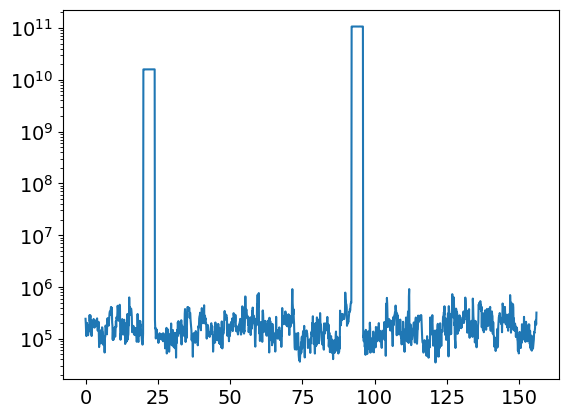

In [54]:
d_sq = []
for i in range(len(task_data_df)):
    d_sq.append(np.sum(np.abs(task_data_df[i]['new_tinyX']-task_data_df[i]['x_imputed'])))

plt.plot(np.arange(len(d_sq))/10,d_sq)
plt.yscale('log')